## AWnet test

In [1]:
from awnet import pwc_5x5_sigmoid_bilinear   # cm:import AWnet model
import torch
from torchvision import transforms, utils

AWnet = pwc_5x5_sigmoid_bilinear.pwc_residual().cuda()
AWnet.load_state_dict(torch.load('awnet/fs_34_all_0.03036882.pkl'))
AWnet = AWnet.eval()

import warnings
warnings.filterwarnings("ignore")

def fuseTwoImages(I, J_hat):
    with torch.no_grad():
        fusedTensor,warp,mask = AWnet(J_hat,I)
    return fusedTensor, warp, mask

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def patchize(img):
    imgs = []
    H, W, C = img.shape
    ph = H//2
    pw = W//2
    img_empty = np.zeros((H+200, W+200, C))
    img_empty[100:-100, 100:-100] = img
    img = img_empty
    for i in range(2):
        for j in range(2):
            imgs.append(img[100+ph*i-50:100+ph*i+ph+50, 100+pw*j-32:100+pw*j+pw+32])
    imgs = np.stack(imgs)
    return imgs

def depatchize(imgs, pd_h = 50, pd_w = 32):
    ph = (imgs[0].shape[0]-2*pd_h)
    pw = (imgs[0].shape[1]-2*pd_w)
    img = np.zeros((ph*2, pw*2, 3))
    for i in range(2):
        for j in range(2):
            img[i*ph:i*ph+ph, j*pw:j*pw+pw] = imgs[i*2+j, pd_h:-pd_h, pd_w:-pd_w]
            
    return img

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(24,12))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [10]:
a = cv2.imread("AWnet_n_AF/700.png")[..., ::-1]/255.#[np.newaxis, :, :, ::-1].transpose(0, 3, 1, 2)/255.
b = cv2.imread("AWnet_n_AF/900.png")[..., ::-1]/255.#[np.newaxis, :, :, ::-1].transpose(0, 3, 1, 2)/255.
a = cv2.resize(a, None, fx=0.5,fy=0.5)
b = cv2.resize(b, None, fx=0.5,fy=0.5)
aa = patchize(a)
bb = patchize(b)
aa = torch.Tensor(aa.transpose(0, 3, 1, 2)).cuda()
bb = torch.Tensor(bb.transpose(0, 3, 1, 2)).cuda()

ccs = []
wws = []
for i in range(4):
    cc, ww, mask = fuseTwoImages(aa[i:i+1], bb[i:i+1])
    ccs.append(cc[0])
    wws.append(ww[0])
cc = torch.stack(ccs)
ww = torch.stack(wws)

c = depatchize(cc.cpu().detach().numpy().transpose(0, 2, 3, 1))
warp = depatchize(ww.cpu().detach().numpy().transpose(0, 2, 3, 1))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


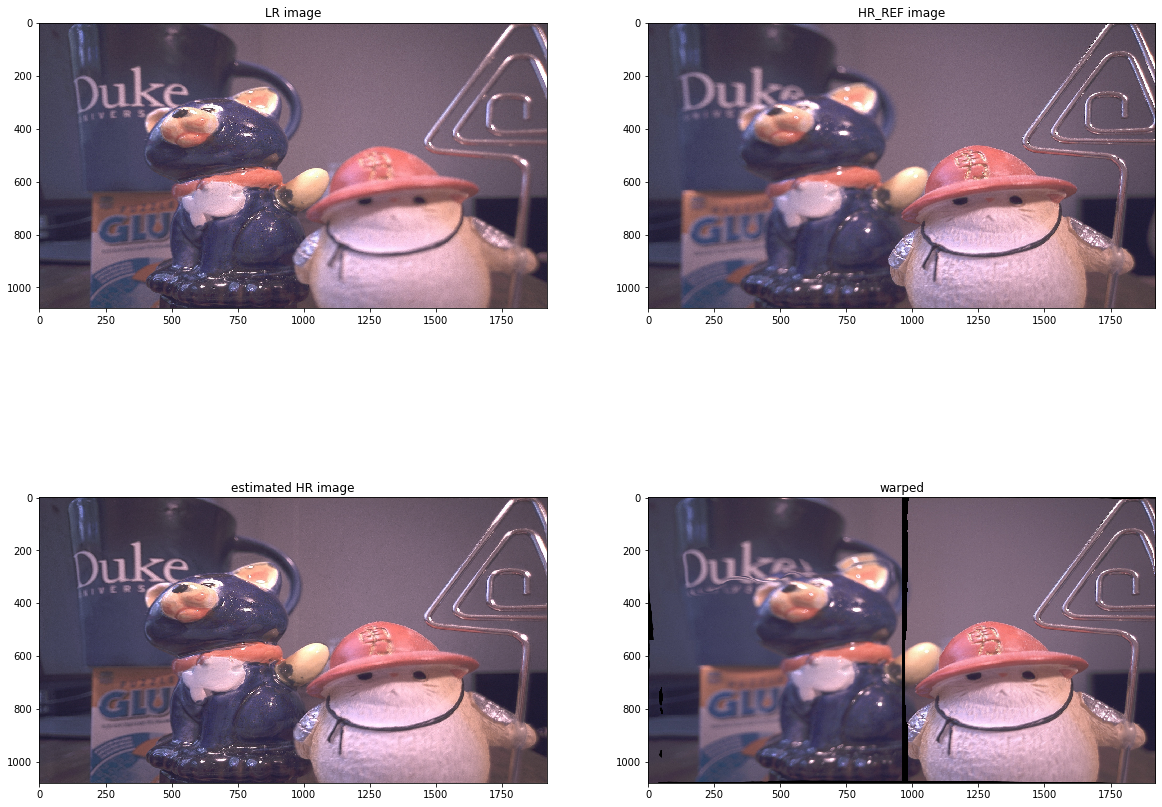

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(20, 16))
ax[0][0].imshow(a) #cv2.resize(a, (896, 512))
ax[0][0].set_title('LR image')
ax[0][1].imshow(b)
ax[0][1].set_title('HR_REF image')
ax[1][0].imshow(c)
ax[1][0].set_title('estimated HR image')
ax[1][1].imshow(warp)
ax[1][1].set_title('warped')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


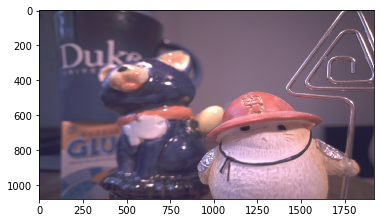

In [6]:
a2 = cv2.blur(a,(5,5))
plt.imshow(a2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


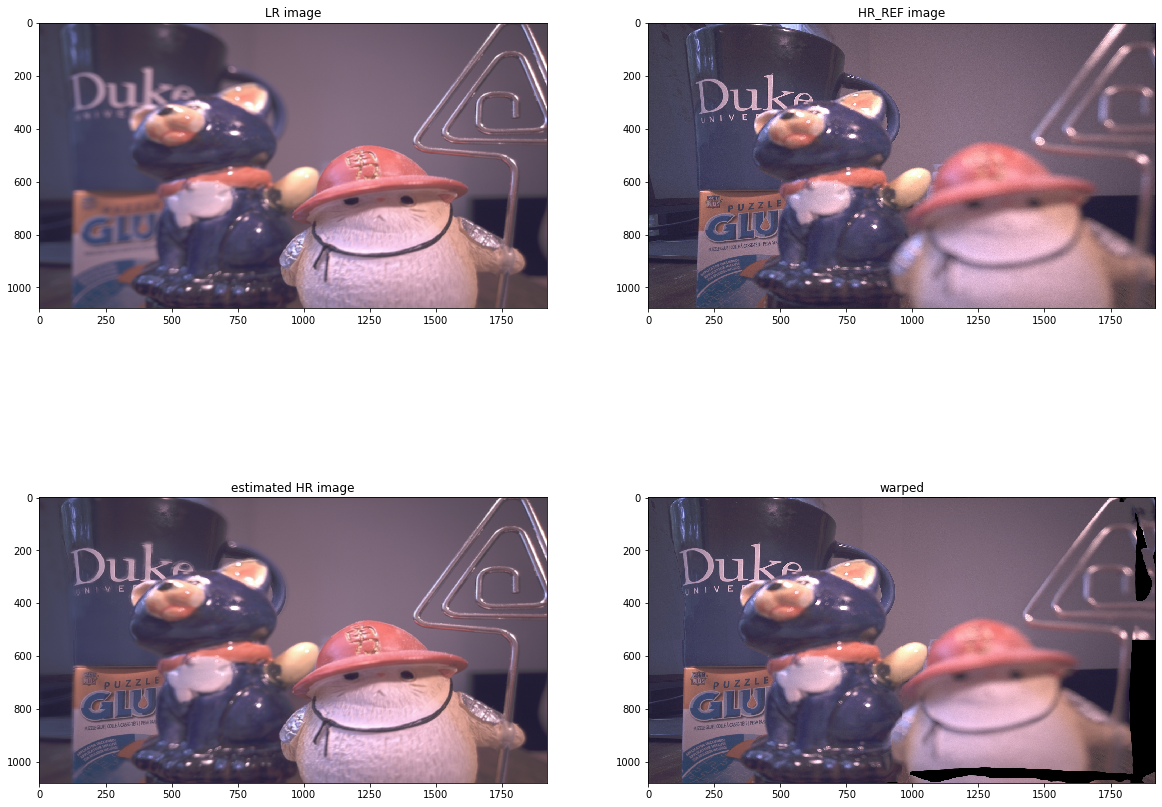

In [7]:
aa = patchize(a2)
aa = torch.Tensor(aa.transpose(0, 3, 1, 2)).cuda()

ccs = []
wws = []
for i in range(4):
    cc, ww, mask = fuseTwoImages(aa[i:i+1], bb[i:i+1])
    ccs.append(cc[0])
    wws.append(ww[0])
cc = torch.stack(ccs)
ww = torch.stack(wws)

c = depatchize(cc.cpu().detach().numpy().transpose(0, 2, 3, 1))
warp = depatchize(ww.cpu().detach().numpy().transpose(0, 2, 3, 1))

fig, ax = plt.subplots(2, 2, figsize=(20, 16))
ax[0][0].imshow(a2) #cv2.resize(a, (896, 512))
ax[0][0].set_title('LR image')
ax[0][1].imshow(b)
ax[0][1].set_title('HR_REF image')
ax[1][0].imshow(c)
ax[1][0].set_title('estimated HR image')
ax[1][1].imshow(warp)
ax[1][1].set_title('warped')
plt.show()